#Predição de Bolsa de Ações da Petrobrás

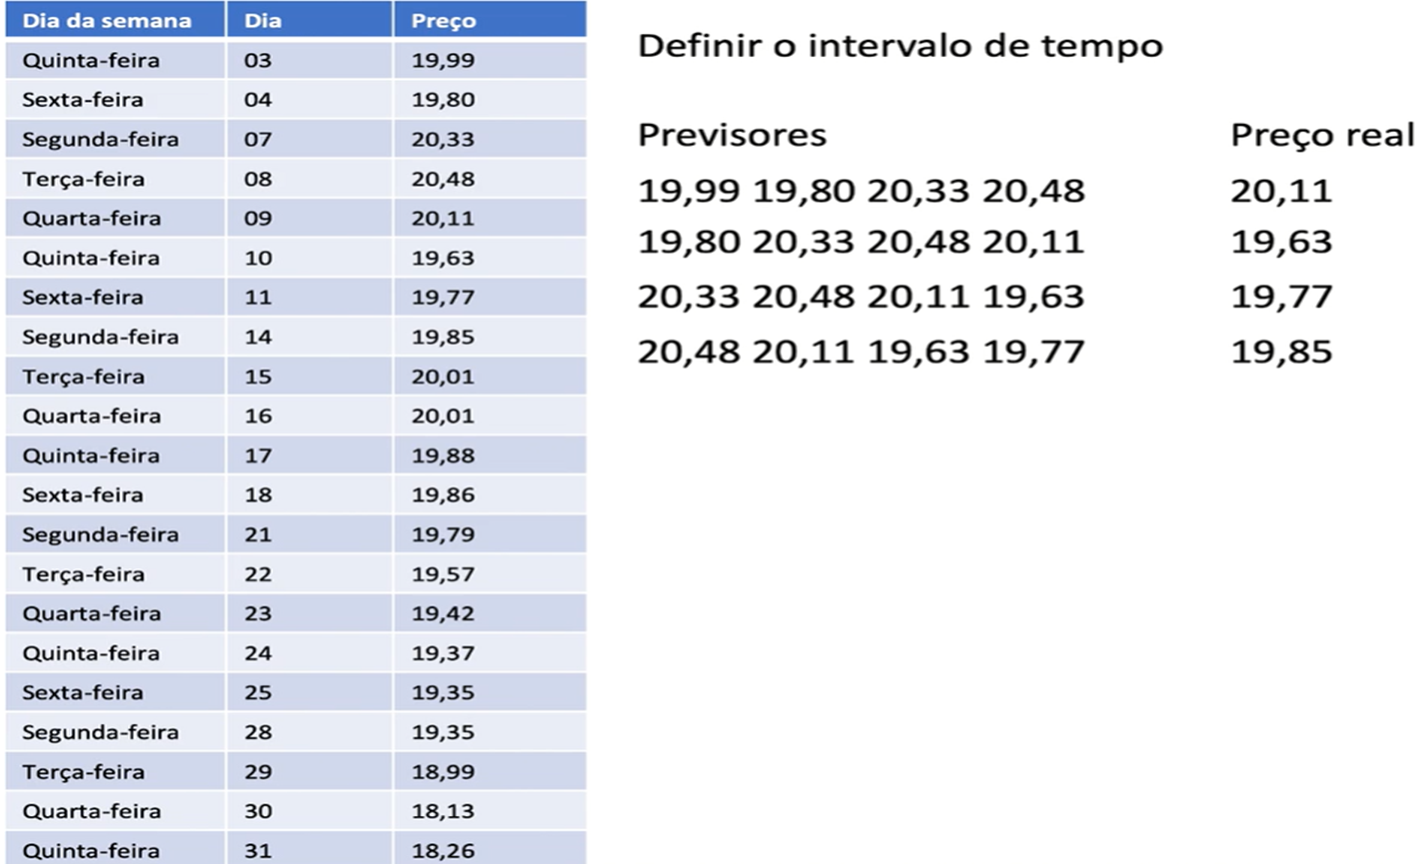

In [ ]:
#Previsor unico  -> X_train com apenas uma feature 

#https://colah.github.io/posts/2015-08-Understanding-LSTMs/

#https://br.financas.yahoo.com


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, LSTM 
from sklearn.preprocessing import MinMaxScaler


In [ ]:
############## Importando o banco de dados petr4_treinamento.csv

#dataset = pd.read_csv('petr4_treinamento.csv')

url='https://github.com/gustavowillam/RNA/blob/main/datasets/regression/petr4_treinamento.csv?raw=true'  

df = pd.read_csv(url, encoding = 'ISO-8859-1')


In [ ]:
print(df)

In [ ]:
df = df.dropna()

sel_cols = ['Open']

df_train = df[sel_cols] 
#df_train = df.iloc[:, 1:2].values   #pega a coluna (open)

In [ ]:
print(df_train)

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))  #normalizar os dados na escala de [0-1]
df_train_sc = scaler.fit_transform(df_train)

In [ ]:
df_train_sc

In [ ]:
#construindo a extrutura da serie temporal, considerando com base nos 90 valores anteriores. 
X_train = []
y_train = []
for i in range(90, 1242):
    X_train.append(df_train_sc[i-90:i, 0])
    y_train.append(df_train_sc[i, 0])

In [ ]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  #redimensionar o conjunto de treinamento para o formato do  keras  -> pesquisar: keras -> layers -> Recorrent Layers -> Input shape (3D) 

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
#Estrutura da Rede Neural LSTM

regressor = Sequential()

regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))  #1 -> indica 1 atributo previdor (coluna open)
                                                                                                   #units = 100 -> número de células de memória  
regressor.add(Dropout(0.3))


#1ª camada oculta 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

#2ª camada oculta 
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

#3ª camada oculta 
regressor.add(LSTM(units = 50)) #ao definir a ultima camada oculta deve-se retirar o return_sequences, para não gerar erro de shape  
regressor.add(Dropout(0.3))

#camada de saída 
regressor.add(Dense(units = 1, activation = 'linear'))

regressor.compile(optimizer = 'rmsprop', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])


In [ ]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
#Previsão do preço de açoes utilizando a base de dados de teste 

############## Importando o banco de dados petr4_teste.csv

#dataset = pd.read_csv('petr4_teste.csv')

url='https://github.com/gustavowillam/RNA/blob/main/datasets/regression/petr4_teste.csv?raw=true'  

df_test = pd.read_csv(url, encoding = 'ISO-8859-1')


In [ ]:
df_test

In [ ]:
y_test = df_test.iloc[:, 1:2].values
df_full = pd.concat((df['Open'], df_test['Open']), axis = 0)
entradas = df_full[len(df_full) - len(df_test) - 90:].values     #extrair os 90 preços anteriores para cada valor do y_test
                                                                 #len(df_full) -> retorna 1264 registros  -> retorna a ultima ação de Jan/18
                                                                 #len(df_test) -> retorna 22 registros (Jan/2018) -> retorna a ultima ação de Dez/17
                                                                 # -90 -> retorna 1264 - 22 - 90 = 1152 ->  ultimas 90 relacionadas ao mês de Janeiro/18
                                                                 #entradas -> 112 registros 
entradas = entradas.reshape(-1, 1)                               #converte entradas para (112,1)
entradas = scaler.transform(entradas)



In [ ]:
df_test.shape

In [ ]:
df_full.shape

In [ ]:
entradas.shape

In [ ]:
X_test = []
for i in range(90, 112):
    X_test.append(entradas[i-90:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predictions = regressor.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [ ]:
predictions

In [ ]:
y_test

In [ ]:
print('valor médio predito:', predictions.mean())
print('valor médio real   :', y_test.mean())


valor médio predito: 17.759945
valor médio real   : 17.87454563636364


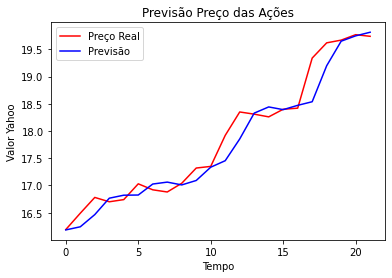

In [ ]:
#Gráfico com preço de ações 

plt.plot(y_test, color = 'red', label = 'Preço Real')
plt.plot(predictions, color = 'blue', label = 'Previsão')
plt.title('Previsão Preço das Ações')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()